# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of transmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

# Introduction to Delay Tolerant Networks

Delay Tolerant Networking (DTN) is a relatively new area of research which 
is rapidly becoming the focus of considerable effort. DTN is an approach
to computer architecture that seeks to address the technical issues in 
heterogeneus networks that may lack continuos network connectivity. The
final aim of this developing study area is to tackle problems which the 
Internet is not able to face.  

There's a great variety among the different DTNs: they range from deep 
space networks to buses driving around mobile wireless hotspots in 
villages to provide Internet service to kiosks. 

The big difference from the regular Internet Protocol (IP) is that IP
assumes a seamless end-to-end data path instead DTNs are built to account
for errors and disconnections. Unlike IP, where heterogeneus networks are 
connected by assigning each node a common network-layer identifier (IP address),
a DTN uses "naming, layering, encapsulation and persistent storage".

The situations in which we use DTNs are pretty challenging:

* The throughput is generally low (we can think for instance about the acoustic in underwater modems) and may 
be highly asymmetric or in the worse scenario a return channel might not 
exist

* These networks are frequently disconnected, not only by faults but due
to motion for instance

* These systems frequently operate with a low duty cycle and the queuing 
time can be very large; with these conditions TCP would time out the session
instead UDP would lose all the packets.

We decided to use 2 different approaches in order to face to routing problem with DTNs. The first one is a greedy
algorithm while the second is an epidemic algorithm. 

Before going into the details of the two different algorithms there are some assumptions that need to be pointed out:
    
* We are working with infinite buffers 

* There are no errors in transmission

* There's a maximum distance between two satellites beyond which they can't communicate

* We keep the same size for every packet

* This is a centralized system, in the sense that Earth knows all the topology of the network


In [4]:
#used to import the utility functions
import sys
sys.path.insert(1, "utility_functions/")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import math
import pylab as pl
from matplotlib import collections  as mc
import mpl_toolkits.mplot3d.axes3d as p3
from network_utilities import generate_network, plot_network, disable_links, adjacency_matrix
from greedy_routing import greedy_routing
from graphics import pkt_plot
from metrics import throughput, delay, deviations
import pandas as pd
from epidemics import epidemic, remove_duplicates
from tqdm.notebook import tqdm
import copy
np.random.seed(100)

################################################
n = 10                                         #
c = 3e8                                        #
T_tx = 10  # da regolare                       #
r_max = 60e9  # Marte                          #
tau_max = 200                                  #
delta_time = 10                                #
################################################

In [5]:
nodes = generate_network(n,r_max,seed=17363720)
A = adjacency_matrix(nodes,tau_max)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth
A = A[sorted_nodes,:][:,sorted_nodes]
nodes = nodes[sorted_nodes]

if(True):   #TEST
    print(nodes.shape)
    print(A.shape)
    print("sorted_nodes: {}".format(sorted_nodes))

(10, 3)
(10, 10)
sorted_nodes: [0 4 7 9 5 2 8 1 6 3]


<IPython.core.display.Javascript object>


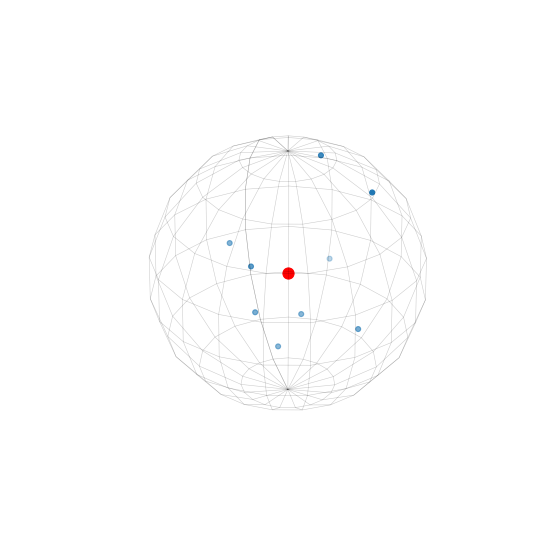

In [6]:
%matplotlib notebook

fig,ax = plot_network(nodes,sphere=True,r_max=r_max)
rotation = True

def rotate(num,ax,rotation):
        ax.azim = 0.5*num*rotation

ax.set_axis_off()
ani = animation.FuncAnimation(fig, rotate, interval=20, fargs=(ax,rotation))
plt.show()

# Greedy Routing

In every network where data is generated from a node and needs to be delivered to a different one, may it be the postal network or the internet, it is necessary to find out the route that the data should follow in order to reach its destination.

This is usually done by a routing algorithm, in the internet the most widely used ones are the Dijikstra and the Bellman-Ford algorithms, these two are used in order to find the shortest path from the source to the destination according to some metric that could be the number of hops, the end to end delay etc.

<!-- The code below is html and I used it because it gives much more freedom for
controlling images-->
<figure>
    <img src="figures/routing.svg" width=500/>
    <div style="text-align: center;"> 
        <i>
            Path obtained by applying routing between the two nodes
        </i>
    </div>
</figure>

Classical routing algorithms do not work on DTNs (Delay Tolerant Networks) because they were thought for systems where links are supposed to fail very rarely and where the end to end delay is relatively small.

In the internet the chance of a link failing is low and even if it does the end to end delay is small, so in case a packet is lost because of link failure sending the packet again is not too expensive.
In DTNs this is not true because:

* The propagation time is very high, expecially if we are considering satellite communication

* The chance of link failure is very high.

On top of that it is not even possible to find the best routing algorithm for networks, this is because if also the traffic generated by other nodes is taken into consideration the problem becomes NP.
By analyzing the state of the art in DTN it is possible to see that the best results are mostly obtained by using greedy algorithms, i. e. algorithms that take a decision by choosing the best choice at each iteration without considering long term planning.

In order to perform routing in this work by hypothesis we have full knowledge of the topology and evolution of the network. This is not a very strict requirement as it might happen in real life, for example for satellite networks, where usually link failure is caused by the interference of a celestial body, the requirement can be easily satisfied.

The first of the two implemented algorithms chooses the best next hop for the packet by using a slightly modified version of the dijkstra algorithm that computes the best path from the source to the destination at a specific point in time.

It is also necessary to take collisions into account, so if sending one packet causes one the sender needs to wait until it is sure that no collision will occur. After the idle time waited in order to avoid collisions the optimal path needs to be recomputed because, due to topology changes, it might not be optimal anymore.

## Modified Dijkstra

In general the Dijkstra algorithm is used to find the best path between two nodes in weighted graphs with positive weights.

<figure>
    <img src="figures/dijkstra.gif" width=300/>
    <div style="text-align: center;"> 
        <i>
            Dijkstra algorithm in action
        </i>
    </div>
</figure>

Usually the algorithm is run on graphs that have fixed topology, unfortunately for DNTs this is not the case, hence a link that was active when the packet was sent might not be active when the packet reaches its destination.

This has to be taken into account because a link failing while a message is being sent through the link will result in packet loss.

An implementation of the Dijkstra algorithm for DTNs that solved this problem was proposed in [1].
With this approach the weight of a node is considered equal to $t_p + t_{tr} + t_w$ where $t_p$ is the propagation time, $t_{tr}$ is the transmission time and $t_w$ is the total time that the sender needs to wait before sending because of link failures.

The pseudo code for the algorithm is:
```
Input = G=(E, V), s, T, w(e,t)
Q = V
L[s]=0
L[v]=inf for every v != s
while Q != {} do
    u = u in Q that minimizes L[u]
    Q = Q - u
    for each edge e in E between u and another vertex v do
        if L[v] > L[u] + w(e, T + L[u]) then
            L[v] = L[u] + w(e, T + L[u])
        end if
    end for
end while
```
Where G is the graph representing the network, s is the starting node, T is the starting time, w(e,t) is the weight of edge e at time t.
The only difference from the standard algorithm is that in the standard case w(e,t) is constant in t, meaning that by correctly computing the function w(e,t) the algorithm will be able to find shortest paths also in the case of changing topology.


In [7]:
%matplotlib inline
#generating some random packets with earth as destination
packets = np.random.randint(1, n, (1000, 2))
packets[:,1] = 0

ttr = T_tx
At = disable_links(A, 100000, delta_time ,mode="unstable")
if True:
    #performing the routing algorithm
    results = greedy_routing(At, packets, ttr, delta_time, with_tqdm =True)
    
    #finding out how many packets transited in one node
    packet_distribution = np.zeros(n)
    
    #for each packet
    for packet in results:
        #for each node in the route
        for node in packet.route:
            #if the node is not the destiantio
            if node != packet.destination:
                packet_distribution[node] += 1


Traceback (most recent call last):
  File "/home/marco/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/marco/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [8]:
#keep copies of the original data for later
initial_nodes = np.copy(nodes)
initial_A = np.copy(A)
packets_greedy = copy.deepcopy(results) 

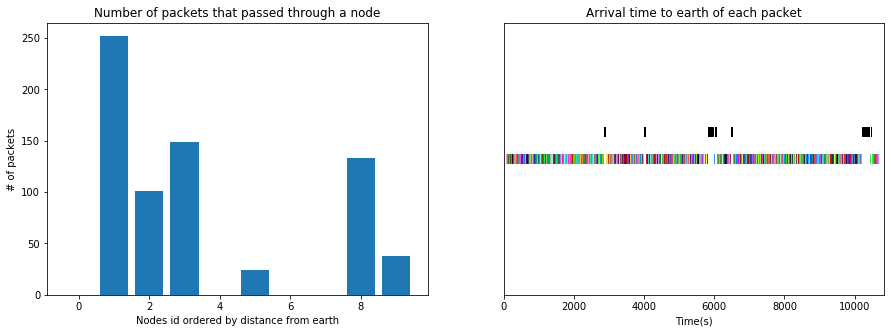

In [9]:
if True:
    _, axs = plt.subplots(1, 2, figsize = (15, 5))
    axs[0].bar(np.arange(n), packet_distribution)
    axs[0].set_title("Number of packets that passed through a node")
    axs[0].set_xlabel("Nodes id ordered by distance from earth")
    axs[0].set_ylabel("# of packets")
    pkt_plot(results, ttr, axs[1]) 

# Interesting observations

The two previous plots enables us to visualize some interesting properties we achieve with greedy routing. 

* The first histogram shows us the number of packets which have passed through a particular node. Given that 
the ordering of the nodes follows the distance from the Earth we immediately notice an intuitive fact that is: 
    the closer a node is to the destination the more packets will pass through it. This reassures us about the 
fact that the greedy algorithm is working properly and so each node is trying to send its packets to nodes
that are closer to Earth.

* With the second plot instead we visualize how efficient we are. Here we are plotting the arrival of the packets 
to destination; the different colors represent the various sources from which the packets have departed. 
The key observation here is that we have basically no idle times since Earth is always receiving packets, this
means that our algorithm is very efficient


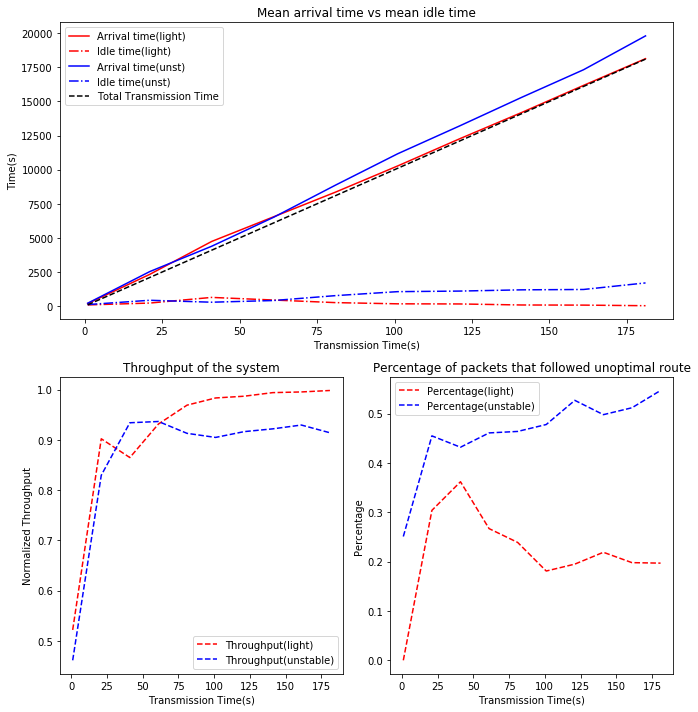

In [10]:
fig = plt.figure(figsize=(10, 10))

#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))

#generating some random packets with earth as destination
packets = np.random.randint(1, n, (100, 2))
packets[:,1] = 0

if True:
    #trying out the outcomes with two different link deactivation modes
    for mode in ["light", "unstable"]:
        
        #choosing the color to be used in the plot
        color = ["blue", "red"]
        color = color[mode == "light"]
        
        #defining the transmission times that will be tested
        ttrs = range(1, 200, 20)
        
        #number of different configurations used for testing
        max_rand = 10
        
        #outputs of the routing algorithm for each configuration and ttr
        outputs = np.zeros((len(ttrs), max_rand))
        deviation_arr = np.zeros((len(ttrs), max_rand))

        for rand_iter in tqdm(range(max_rand)):

            #generate a new configuration
            nodes = generate_network(n,r_max)
            A = adjacency_matrix(nodes,tau_max)
            At = disable_links(A,500000, delta_time, mode=mode)

            #for each transmission time
            for ttr_ind in range(len(ttrs)):

                #calculate the route of each packet
                results = greedy_routing(At, packets, ttrs[ttr_ind], delta_time)
                #finding out the arrival times of each packet
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                #the overall transmission time is the maximum of the arrival times
                outputs[ttr_ind, rand_iter] = np.max(arrival_times)
                #getting the number of packets that followed a route different from the ideal one
                deviation_arr[ttr_ind, rand_iter] = deviations(A, results)

        #finding the mean over the different configurations of the arrival times
        arrival_times = np.mean(outputs, axis = 1)

        #plotting
        axs[0].plot(ttrs, arrival_times, linestyle="-", c = color)
        axs[0].plot(ttrs, arrival_times - packets.shape[0] * np.array(ttrs), linestyle="-.", c=color)
        axs[1].plot(ttrs, throughput(packets.shape[0], arrival_times)*np.array(ttrs), linestyle="--", c = color)
        axs[2].plot(ttrs, np.mean(deviation_arr, axis = 1), linestyle="--", c = color)

    axs[0].plot(ttrs, packets.shape[0] * np.array(ttrs), linestyle = "--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("Transmission Time(s)")
    axs[0].set_title("Mean arrival time vs mean idle time")

    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time",
    ])

    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("Transmission Time(s)")
    axs[1].legend([
        "Throughput(light)",
        "Throughput(unstable)"
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("Transmission Time(s)")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])
    plt.tight_layout()

# An insight on the plots

With the first plot we are visualizing the arrival time, the idle time and the total transmission time as 
a function of the transmission time.

 * What we get is that the idle time remains almost equal to zero even if we increase the transmission time a 
lot. The total transmission time instead increases linearly whereas the arrival time is simply the sum of the
idle time and the total transmission time. As we see, basically there's no difference between the light and the 
unstable mode.


 * With the second plot we want to point out the dependency of the throughput on the Transmission Time; the throughput 
of the system increases really quickly in the first 50 seconds of time and then it reaches a plateau where the throughput
is greater than 0.9. Also here the behaviour we have with light mode is almost identical to the one we get with unstable mode.


 * With the third plot instead we are highlighting the percentage of packets that followed unoptimal route as a function
of the transmission time. What we can observe is something very intuitive: the bigger the transmission time, the 
higher the percentage will be. Here instead we can spot a big difference between light and unstable mode. Given the 
fact that with unstable mode we are shutting down many more links than with light mode we see that the percentage
of packets that followed unpotimal route is much higher with unstable than with light mode.

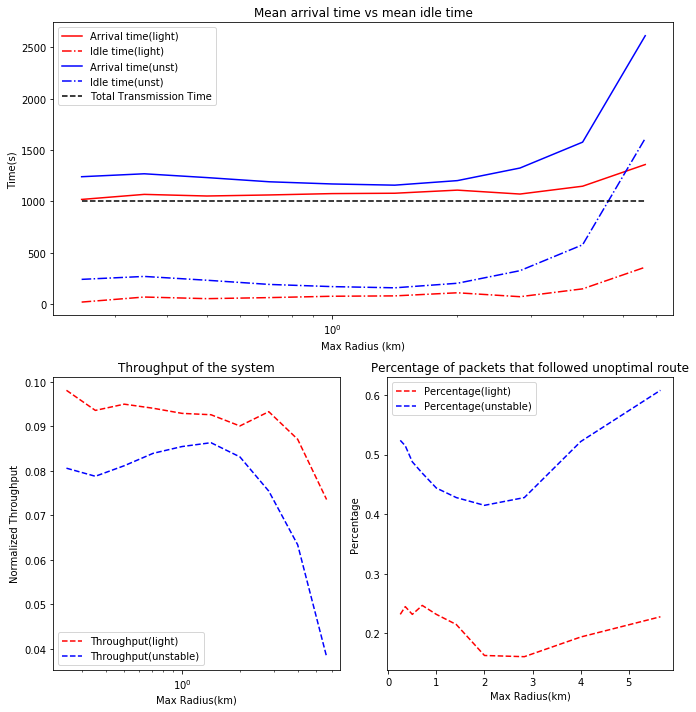

In [11]:
ttr = T_tx
fig = plt.figure(figsize=(10, 10))

#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))


if True:
    #iterating over two different modes
    for mode in ["light", "unstable"]:
    
        color = ["blue", "red"]
        color = color[mode == "light"]
    
        #constants that multiplied by the propagation times simulate the expansion of the configuration
        r_maxes = [2**((i-4)/2) for i in range(10)]
        
        #temporary variables used to store 
        outputs = np.zeros((len(r_maxes), max_rand))
        deviation_arr = np.zeros((len(r_maxes), max_rand))

        #for each different configuration
        for rand_iter in tqdm(range(max_rand)):

            #generating a configuration
            nodes = generate_network(n, r_max)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A,200000, delta_time, mode=mode)

            #for each constant
            for i in range(len(r_maxes)):

                #keeping the same configuration but rescaling the proagation times
                results = greedy_routing(At*r_maxes[i], packets, ttr, delta_time)
                
                #getting the overall transmission time and the number of unoptimal routes
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                outputs[i, rand_iter] = np.max(arrival_times)
                deviation_arr[i, rand_iter] = deviations(A*r_maxes[i], results)

        arrival_times = np.mean(outputs, axis = 1)
        axs[0].semilogx(r_maxes, arrival_times, linestyle="-", c = color)
        axs[0].semilogx(r_maxes, arrival_times - packets.shape[0] * ttr, linestyle="-.", c = color)
        axs[1].semilogx(r_maxes, throughput(packets.shape[0], arrival_times), linestyle="--", c = color)
        axs[2].plot(r_maxes, np.mean(deviation_arr, axis = 1), linestyle="--", c = color)

    axs[0].semilogx(r_maxes, np.ones(len(r_maxes))*packets.shape[0] * ttr, linestyle="--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("Max Radius (km)")
    axs[0].set_title("Mean arrival time vs mean idle time")
    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time"
    ])

    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("Max Radius(km)")
    axs[1].legend([
        "Throughput(light)", 
        "Throughput(unstable)",
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("Max Radius(km)")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])
    plt.tight_layout()    



# An insight on the plots 

With the first plot we are visualizing the arrival time, the idle time and the total transmission 
time as a function of the maximum radius under light and unstable mode.
What we see is that:
    
* The total transmission time is constant

    
* Either with light and unstable mode the idle time is almost constant up to a certain radius. This
    constant is close to zero for light mode whereas for unstable mode it is about 300 seconds. Then from 
    a certain radius on we see an increse which for light mode is very slow and instead for the unstable 
    mode is very fast.

* For the arrival time we experience a very similar behaviour as for the idle time. The plot is almost identical 
to the one for the idle times but it is moved upwards of 1000 seconds.


With the second image we're pointing out the throughput as a function of the maximum radius; what we observe is that 
the behaviour under light and unstable mode is similar but of course light mode gives us a higher throughput. Anyway
for both modes the throughput is almost constant (for the unstable mode the constant is centered at 0.08 instead for 
                                                 the light mode it is centered at 0.09) and then from a certain radius 
it falls down quickly.
  

In the last image we can observe the percentage of packets that followed unoptimal routes as a function of the maximum
radius. What we get for the two different modes is a similar behaviour. 

* For the light mode the best radius is slightly smaller than 3 km and the related percentage is smaller than 0.20
    

* For the unstable mode the best radius is about 1.5 km and the related percentage is slightly smaller than 0.40

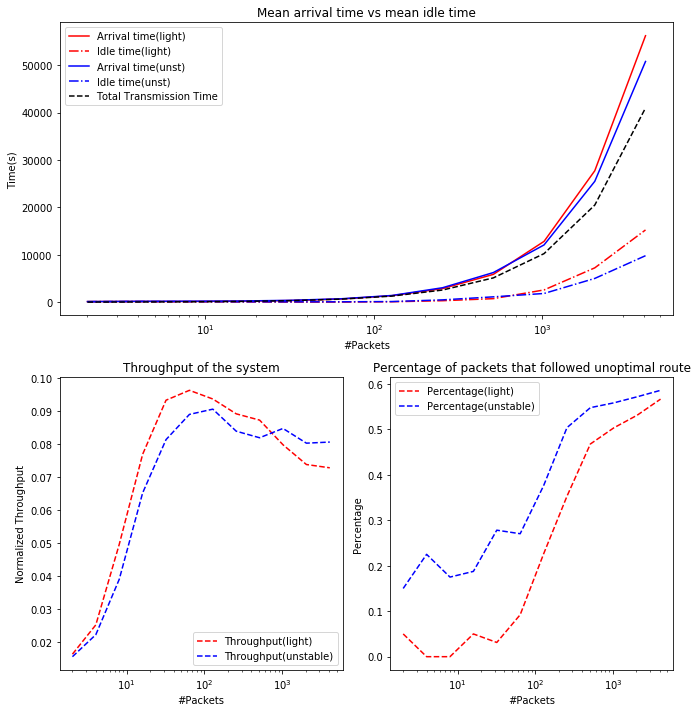

In [12]:
fig = plt.figure(figsize=(10, 10))
#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
ttr = T_tx
max_rand = 10
if True:
    for mode in ["light", "unstable"]:

        color = ["blue", "red"]
        color = color[mode == "light"]

        #changing the number of packets
        packet_numbers = [2**i for i in range(1,13)]
        
        outputs = np.zeros((len(packet_numbers), max_rand))
        deviation_arr = np.zeros((len(packet_numbers), max_rand))

        for rand_iter in tqdm(range(max_rand)):

            nodes = generate_network(n,r_max)
            A = adjacency_matrix(nodes,tau_max)
            At = disable_links(A,200000, delta_time, mode=mode)
        
            for i in range(len(packet_numbers)):

                    #generating new packets every time since their number changes at every iteration
                    packets = np.random.randint(1, n, (packet_numbers[i], 2))
                    packets[:,1] = 0

                    results = greedy_routing(At, packets, ttr, delta_time)
                    arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                    outputs[i, rand_iter] = np.max(arrival_times)
                    deviation_arr[i, rand_iter] = deviations(A, results)

        arrival_times = np.mean(outputs, axis = 1)

        axs[0].semilogx(packet_numbers, arrival_times, linestyle="-", c = color)
        axs[0].semilogx(packet_numbers, arrival_times - np.array(packet_numbers) * ttr, linestyle="-.", c=color)
        axs[1].semilogx(
            packet_numbers, 
            throughput(np.array(packet_numbers), arrival_times), 
            linestyle="--",
            c=color
        )
        axs[2].semilogx(packet_numbers, np.mean(deviation_arr, axis = 1), linestyle="--", c=color)

    axs[0].semilogx(packet_numbers, np.array(packet_numbers) * ttr, linestyle = "--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("#Packets")
    axs[0].set_title("Mean arrival time vs mean idle time")
    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time"
    ])


    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("#Packets")
    axs[1].legend([
        "Throughput(light)", 
        "Throughput(unstable)",
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("#Packets")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])

    plt.tight_layout()

In [ ]:
# An insight on the plots

With the first plot we are visualizing the arrival time, the idle time and the total transmission 
time as a function of the maximum radius under light and unstable mode.
What we see is that:
    
* We observe a very similar behaviour under light and unstable mode

    
* Up to 100 packets the total transmission time, the arrival and idle time are very close to zero then
both the idle and total transmission time start growing; the first increases smoothly while the latter 
pretty quickly. Then as we can see the arrival time is given by the sum of idle time and total transmission time.

* We observe that for the idle time and so also for the arrival time, it is higher under unstable mode as we were 
expecting


With the second image we're pointing out the throughput as a function of the number of packets; what we observe is that 
the behaviour under light and unstable mode is similar but of course light mode gives us a higher throughput. Anyway
for both modes the normalized throughput grows very quickly and then it stabilizes at a value in between 0.08 and 0.10.
  

In the last image we can observe the percentage of packets that followed unoptimal routes as a function of the number of packets. What we get for the two different modes is a similar behaviour. 

Under both modes we observe a similar behaviour: the more the packets the higher the percentage of packets that follows
unoptimal routes. Anyway as we could expect the percentage is always higher with unstable mode.


## Epidemic Algorithm
A key problem affecting DTNs is the fact that the topology of network changes a lot over time. In some cases, it is not possible to predict these network changes. For example in our case study, some celestial bodies could suddenly pass between the Earth and our satellites causing the link to fail and we cannot know if and when the link will become active again.<br> 
The epidemic algorithm suggests an approach that we can use to solve these types of problems,because it does not require a complete previous knowledge of the network topology. The algorithm works like an epidemic; if it is not possible to send packets to Earth, each node spreads the packets to all nearby nodes. So this procedure creates many copies of the same packet, in fact pure Epidemic routing has usually a high message delivery ratio. We can see below the main phases of the algorithm.<br>

   * 1) If the link is up the packets are sent from the node to the Earth, if the link is down the packets are sent to all nearby nodes that they can reach(the topology of network is full-connected, but it is possible that some links are temporarily interrupted)<br><br>
   
   * 2) This procedure is repeated for all nodes over time, until all the packets have arrived to Earth. But if a node has already sent a copy of the packets to its neighbour, it doesn't need to send it back.<br><br>
   
   * 3) It is possible that the packet is discarded. This happens when: the packet is sent but during the propagation time the link breaks or when the packet arrives but there are some collisions on the receiver because other packets arrive in the same moment.<br><br>
   
Using Epidemic algorithm, unless a node always remains isolated, we are sure that all packets arrive to Earth. The problem is that many copies of the same packet can create a congestion in the network and an increase of total energy consumption for data transmission.
In this algorithm we assume to know the topology of network, namely if the links are active or not, only in the current moment in which we are. We have no information about the future, so we cannot route efficiently the packets, like it happens in the algorithms above.


# of unique packets that reached earth 250
# of packets that reached earth 676
vulnerable times:  [6862.79220964 6738.15923314 5542.24377311 5971.69246302 6228.82724012
 5772.62995605 6380.         5927.01486474 6248.8435859  5220.57551974]


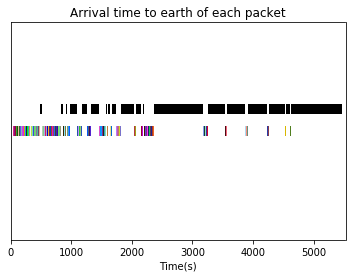

In [10]:
transmission_time = T_tx
slot_time = delta_time

#generating new packets with earth as a destination
packets = np.random.randint(1, n, (250, 2))
packets[:, 1] = 0

#generating the new configuration
At = disable_links(A, 100000, slot_time, mode="unstable")

#performing the routing algorithm
packet_arrive, packet_time, vulnerable, anim_packets = epidemic(
    At,
    transmission_time,
    slot_time,
    packets,
    return_anim=True
)

#the set is a data structure that removes all duplicates
print('# of unique packets that reached earth', len(set(packet_arrive)))
print('# of packets that reached earth', len(packet_arrive))
#notice that the earth might receive packets even after the last useful packet arrives
print("vulnerable times: ", vulnerable)

#filtering packets that arrived to earth and removing duplicates
packets_to_earth = remove_duplicates(list(filter(lambda x: x.route[0] == 0, anim_packets)))

pkt_plot(packets_to_earth, transmission_time)

### An insight on the plots

With the first plot we are visualizing the arrival time and the total transmission time as a function of the number of packets in two different network configurations.
What we get is that the arrival time increases exponentially in both configurations.<br>
With the second plot we want to point out the dependency of the packet delivery ratio on the number of packets, in order to understand how the number of duplicate packets in the network changes.<br>
In the plot below, we have repeated the same figure but we have halved the maximum radius of transmission and incresed the number of nodes. In this case, as we could expect, packet fraction reaches lower values, because some nodes cannot send the packets to Earth directly so the number of duplicate packets obviously will be incresed.<br>
With the second figure we are visualizing the arrival time as a function of transmission time and the packet delivery ratio using the same configuration as above. We can see that, in case we halve the maximum radius of transmission, the arrival time increases because the network is more congested.


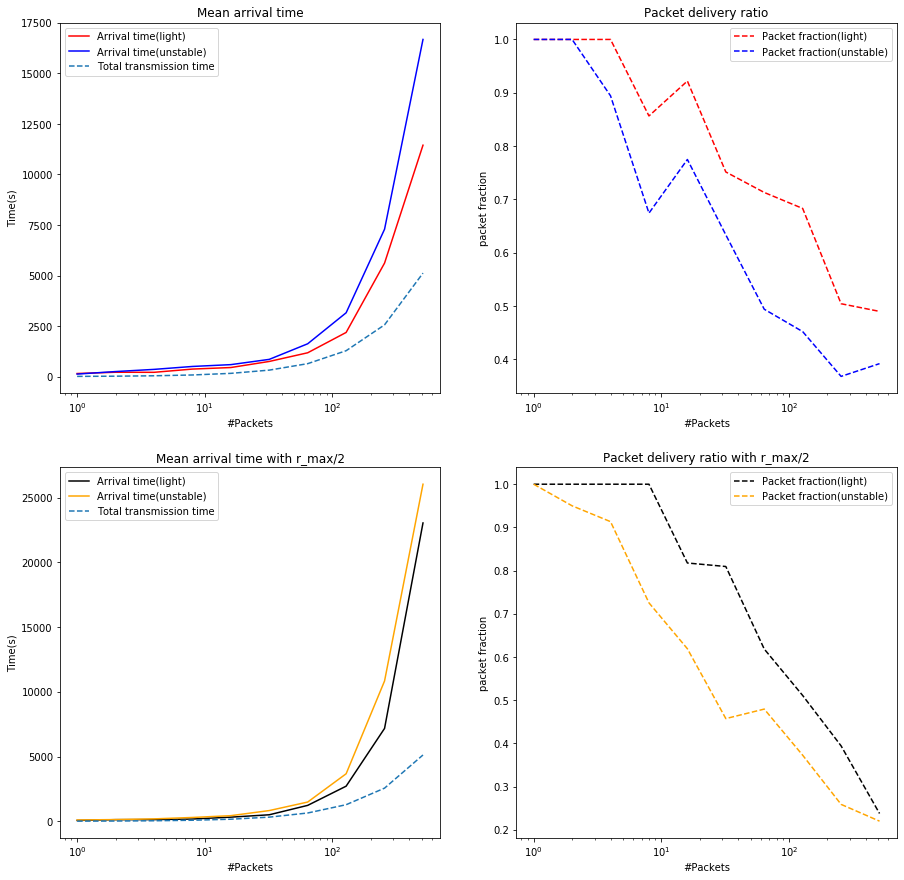

In [11]:
#generate figure
fig = plt.figure(figsize=(15, 15))
    
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
#seeing how the system behaves as number of packets increases
max_rand = 10

if True:
    #plots and analysis with 10 nodes and r_max
    for mode in ["light", "unstable"]:

        color = ["blue", "red"]
        color = color[mode == "light"]
        
        #number packet that we want to send to earth
        packet_numbers = [2**i for i in range(10)]
        
        #temp variables used to store data that will be used for the plots
        arrival_times = np.zeros((len(packet_numbers), max_rand))
        packet_fraction = np.zeros((len(packet_numbers), max_rand))

        for sample in tqdm(range(max_rand)):

            #generating a new network configuration
            nodes = generate_network(n, r_max)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A, 100000, slot_time, mode = mode)

            for i in range(len(packet_numbers)):

                #generating new packets with earth as a destination
                packets = np.random.randint(1, n, (packet_numbers[i], 2))
                packets[:, 1] = 0
                
                #performing the routing algorithm
                packet_arrive, _, vulnerable = epidemic(At, transmission_time, slot_time, packets)
                arrival_times[i, sample] = vulnerable[0] + transmission_time
                packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

        axs[0].semilogx(packet_numbers, np.mean(arrival_times, axis = 1), c = color)
        axs[1].semilogx(packet_numbers, np.mean(packet_fraction, axis = 1), c = color, linestyle="--")

    #plots and anlysis with 20 nodes and r_max/2
    for mode in ["light", "unstable"]:

        color = ["orange", "black"]
        color = color[mode == "light"]
        
        arrival_times = np.zeros((len(packet_numbers), max_rand))
        packet_fraction = np.zeros((len(packet_numbers), max_rand))

        for sample in tqdm(range(max_rand)):
        
            #generating a new configuration
            nodes = generate_network(n*2, r_max/2)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A, 100000, slot_time, mode = mode)

            for i in range(len(packet_numbers)):

                #generating new packets with earth as a destination
                packets = np.random.randint(1, n*2, (packet_numbers[i], 2))
                packets[:, 1] = 0
                
                #computing the routing algorithm
                packet_arrive, _, vulnerable = epidemic(At, transmission_time, slot_time, packets)
                arrival_times[i, sample] = vulnerable[0] + transmission_time
                packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

        axs[2].semilogx(packet_numbers, np.mean(arrival_times, axis = 1), c = color)
        axs[3].semilogx(packet_numbers, np.mean(packet_fraction, axis = 1), c = color, linestyle="--")


    axs[0].semilogx(packet_numbers, np.array(packet_numbers)*transmission_time, linestyle="--")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("#Packets")
    axs[0].set_title("Mean arrival time")
    axs[0].legend([
        "Arrival time(light)",
        "Arrival time(unstable)",
        "Total transmission time"
    ])

    axs[1].set_ylabel("packet fraction")
    axs[1].set_xlabel("#Packets")
    axs[1].set_title("Packet delivery ratio")
    axs[1].legend([
        "Packet fraction(light)",
        "Packet fraction(unstable)"
    ])

    axs[2].semilogx(packet_numbers, np.array(packet_numbers)*transmission_time, linestyle="--")
    axs[2].set_ylabel("Time(s)")
    axs[2].set_xlabel("#Packets")
    axs[2].set_title("Mean arrival time with r_max/2")
    axs[2].legend([
        "Arrival time(light)",
        "Arrival time(unstable)",
        "Total transmission time"
    ])

    axs[3].set_ylabel("packet fraction")
    axs[3].set_xlabel("#Packets")
    axs[3].set_title("Packet delivery ratio with r_max/2")
    axs[3].legend([
        "Packet fraction(light)",
        "Packet fraction(unstable)"
    ])


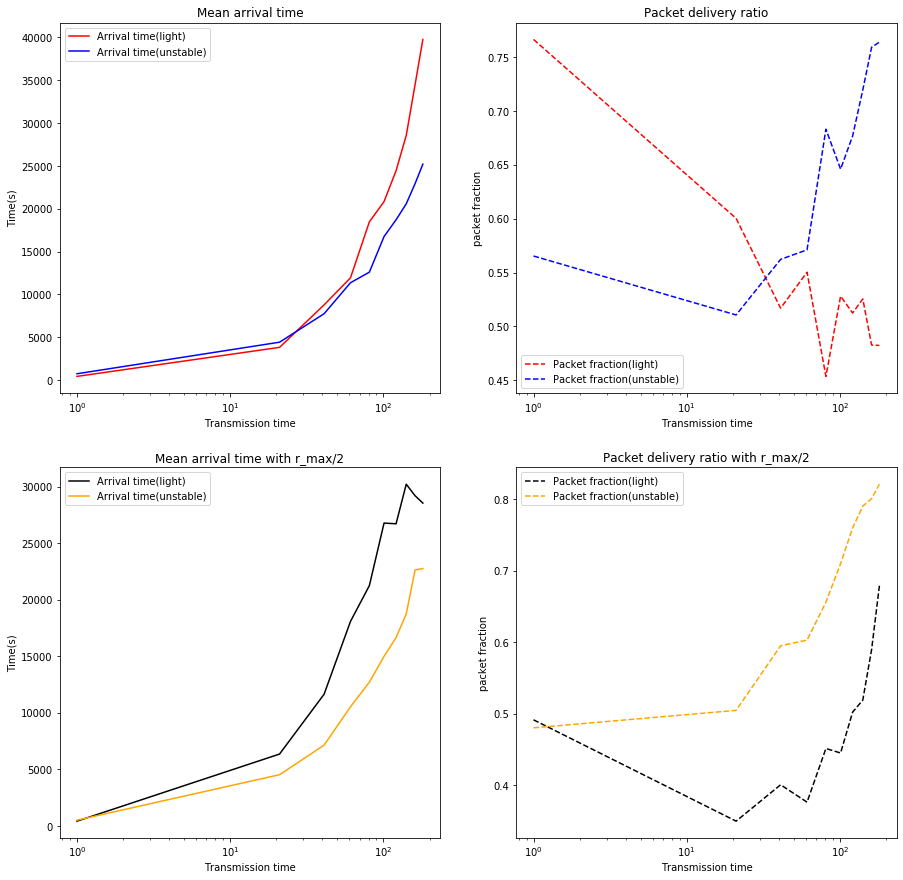

In [12]:
#generate figure
fig = plt.figure(figsize=(15, 15))
   
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))

#seeing how the system behaves as the transmission time increases
max_rand = 10
packet_numbers = 100

if True:
    for mode in ["light", "unstable"]:

        color = ["blue", "red"]
        color = color[mode == "light"]

        transm_time = np.arange(1, 200, 20)
        arrival_times = np.zeros((len(transm_time), max_rand))
        packet_fraction = np.zeros((len(transm_time), max_rand))

        for sample in tqdm(range(max_rand)):

            nodes = generate_network(n, r_max)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A, 100000, slot_time, mode = mode)

            for i in range(len(transm_time)):

                packets = np.random.randint(1, n, (packet_numbers, 2))
                packet_arrive, _, vulnerable = epidemic(At, transm_time[i], slot_time, packets)
                arrival_times[i, sample] = vulnerable[0] + transm_time[i]
                packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

        axs[0].semilogx(transm_time, np.mean(arrival_times, axis = 1), c = color)
        axs[0].set_ylabel("Time(s)")
        axs[0].set_xlabel("Transmission time")
        axs[0].set_title("Mean arrival time")
        axs[0].legend([
        "Arrival time(light)",
        "Arrival time(unstable)",
        ])

        axs[1].semilogx(transm_time, np.mean(packet_fraction, axis = 1), c = color, linestyle = "--")
        axs[1].set_ylabel("packet fraction")
        axs[1].set_xlabel("Transmission time")
        axs[1].set_title("Packet delivery ratio")
        axs[1].legend([
        "Packet fraction(light)",
        "Packet fraction(unstable)"
        ])

    for mode in ["light", "unstable"]:

        color = ["orange", "black"]
        color = color[mode == "light"]

        arrival_times = np.zeros((len(transm_time), max_rand))
        packet_fraction = np.zeros((len(transm_time), max_rand))

        for sample in tqdm(range(max_rand)):

            nodes = generate_network(n*2, r_max/2)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A, 100000, slot_time, mode = mode)

            for i in range(len(transm_time)):

                packets = np.random.randint(1, n*2, (packet_numbers, 2))
                packet_arrive, _, vulnerable = epidemic(At, transm_time[i], slot_time, packets)
                arrival_times[i, sample] = vulnerable[0] + transm_time[i]
                packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

        axs[2].semilogx(transm_time, np.mean(arrival_times, axis = 1), c = color)
        axs[2].set_ylabel("Time(s)")
        axs[2].set_xlabel("Transmission time")
        axs[2].set_title("Mean arrival time with r_max/2")
        axs[2].legend([
        "Arrival time(light)",
        "Arrival time(unstable)",
        ])


        axs[3].semilogx(transm_time, np.mean(packet_fraction, axis = 1), c = color, linestyle = "--")
        axs[3].set_ylabel("packet fraction")
        axs[3].set_xlabel("Transmission time")
        axs[3].set_title("Packet delivery ratio with r_max/2")
        axs[3].legend([
        "Packet fraction(light)",
        "Packet fraction(unstable)"
        ])


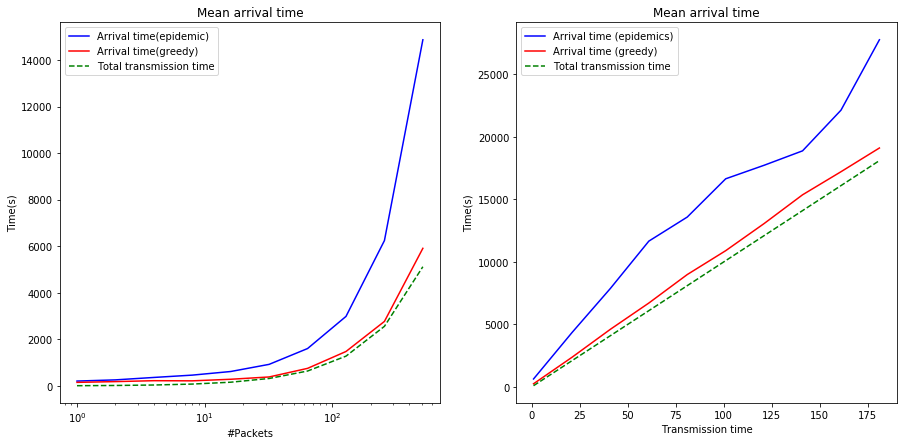

In [13]:
#generate figure
fig = plt.figure(figsize=(15, 7))
    
gs = fig.add_gridspec(1, 2)
axs = []
axs.append(fig.add_subplot(gs[0]))
axs.append(fig.add_subplot(gs[1]))
max_rand = 10

if True:
    
    #different transmission times
    transm_time = np.arange(1, 200, 20)
    
    #number packet that we want to send to earth
    packet_numbers = [2**i for i in range(10)]
    
    #temp variables needed for plots
    arrival_times = np.zeros((len(packet_numbers), max_rand))
    outputs = np.zeros((len(packet_numbers), max_rand))
    outputs_ttr = np.zeros((len(packet_numbers), max_rand))
    arrival_times_ttr = np.zeros((len(packet_numbers), max_rand))
        
    for sample in tqdm(range(max_rand)):

        #generating a new configuration
        nodes = generate_network(n, r_max)
        A = adjacency_matrix(nodes, tau_max)
        At = disable_links(A, 100000, slot_time, mode = "unstable")
        
        #getting the arrival times as the number of packets changes
        for i in range(len(packet_numbers)):
    
            packets = np.random.randint(1, n, (packet_numbers[i], 2))
            packets[:, 1] = 0
            
            #greedy routing results
            results = greedy_routing(At, packets, transmission_time, delta_time)
            
            #epidemic routing results
            packet_arrive, _, vulnerable = epidemic(At, transmission_time, slot_time, packets)
            
            arrival_times_greedy = np.array([packet.arrival_times[-1] for packet in results])
            outputs[i, sample] = np.max(arrival_times_greedy)
            arrival_times[i, sample] = vulnerable[0] + transmission_time

        #getting the arrival times as the transmission time changes
        for i in range(len(transm_time)):
            
            packets = np.random.randint(1, n, (100, 2))
            packets[:, 1] = 0
            
            #greedy routing results
            results = greedy_routing(At, packets, transm_time[i], delta_time)
            
            #epidemic routing results
            packet_arrive, _, vulnerable = epidemic(At, transm_time[i], slot_time, packets)
            
            arrival_times_greedy = np.array([packet.arrival_times[-1] for packet in results])
            outputs_ttr[i, sample] = np.max(arrival_times_greedy)
            arrival_times_ttr[i, sample] = vulnerable[0] + transm_time[i]
            
    arrival_times_greedy = np.mean(outputs, axis = 1)
    axs[0].semilogx(packet_numbers, np.mean(arrival_times, axis = 1), c= "blue")
    axs[0].semilogx(packet_numbers, arrival_times_greedy, c="red")

    axs[0].semilogx(packet_numbers, np.array(packet_numbers)*transmission_time, linestyle="--", color="green")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("#Packets")
    axs[0].set_title("Mean arrival time")
    axs[0].legend([
        "Arrival time(epidemic)",
        "Arrival time(greedy)",
        "Total transmission time"
    ])

    arrival_times_greedy = np.mean(outputs_ttr, axis = 1)
    axs[1].plot(transm_time, np.mean(arrival_times_ttr, axis = 1), color = "blue")
    axs[1].plot(transm_time, arrival_times_greedy, color = "red")
    axs[1].plot(transm_time, np.array(transm_time)*100,color="green" ,linestyle="--")
    axs[1].set_ylabel("Time(s)")
    axs[1].set_xlabel("Transmission time")
    axs[1].set_title("Mean arrival time")
    axs[1].legend([
        "Arrival time (epidemics)",
        "Arrival time (greedy)",
        "Total transmission time"
    ])


# Comparison between greedy and epidemic approach

With the plot on the left we are displaying the arrival time and the total transmission time as a function of the 
number of packets. 
As we can observe the arrival time with the epidemic approach increases much faster than with the greedy one. This 
confirms our expectations, because since the beginning we knew that the greedy algorithm was the one with the strictest
hypothesis but also the most efficient. Anyway we also explored the epidemic approach since this may be useful in some
situations given that it is more robust.


With the plot on the right we are visualizing the arrival time and the total transmission time as a function of the
transmission time. Also here the arrival time with the epidemic approach increases much faster than with the greedy one.
And again this confirms our expectations.


In [14]:
if False:    #for testing purposes, to be removed
    ## ANIMATION 1

    #enable first line to make the animation work
    #WARNING: all other figures will be affected until you restart the kernel

    #%matplotlib notebook 

    coord = generate_network(n,r_max, seed = 1)
    polar = generate_network(n,r_max,polar=True, seed = 1)
    print()

    def update_graph(num):

        theta = polar[:,1]
        phi = polar[:,2]

        old_r = np.linalg.norm(coord,axis=1)

        coord[:,0] += - c*np.cos(theta)*np.sin(phi)
        coord[:,1] += - c*np.sin(theta)*np.sin(phi)
        coord[:,2] += - c*np.cos(phi)

        new_r = np.linalg.norm(coord,axis=1)

        not_done = new_r < old_r  #this happens after a packet reach Earth

        #coord = coord * not_done.reshape((n,-1))  #sets coordinates of a pkt to 0 if it already reached Earth

        for i in range(n):    # ISSUE: previous line doesn't work, this "for" cycle is a substitute
            if not not_done[i]:
                coord[i,0] = coord[i,1] = coord[i,2] = 0

        graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
        title.set_text("time={}".format(num))


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    title = ax.set_title('Pkts')

    graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2])
    ax.scatter(0,0,0,color="red",s=60)   #Earth

    ani = animation.FuncAnimation(fig, update_graph, 
                                   interval=50, blit=False)

    plt.show()

<IPython.core.display.Javascript object>


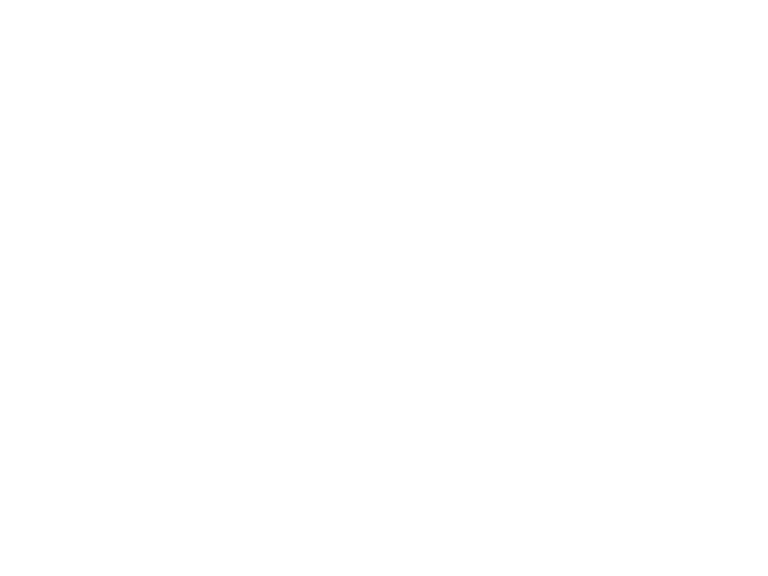

In [15]:
## ANIMATION 2

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

%matplotlib notebook 

nodes = generate_network(n,r_max, seed = 100)

#returns a list of active links
def get_links(A):
    n = A.shape[0]
    return [np.array([nodes[i],nodes[j]]).T for i in range(n) for j in range(i+1) if A[i,j]!=np.inf]

#checks if a link is active 
def check_active(link, link_list):
    for x in link_list:
        if np.array_equal(x, link):
            return True
    return False

A = adjacency_matrix(nodes, tau_max)
At = disable_links(A,5000,1,mode="unstable")  #test

n_updates = At.shape[2]
links = get_links(A)
active_links = [get_links(At[:,:,t]) for t in range(n_updates)]

def update_lines(num, dataLines, lines) :

    title.set_text("time={}".format(num))
    
    for line, data in zip(lines, dataLines) :
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :])
        line.set_3d_properties(data[2, :])
        line.set_color("black")
        if not check_active(data, active_links[num]):
              line.set_color("red")
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

data = links
lines = [ax.plot(dat[0, :], dat[1, :], dat[2, :],alpha=0.5)[0] for dat in links]

if True:   #autoscale off
    # Setting the axes properties
    ax.set_xlim3d([-4e10, 4e10])
    ax.set_xlabel('X')

    ax.set_ylim3d([-4e10, 4e10])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-4e10,4e10])
    ax.set_zlabel('Z')

title = ax.set_title('Links')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, n_updates, fargs=(data, lines),
                              interval=10, blit=False)

plt.show()

In [16]:
def get_vel(node1, node2):
    diff = node2 - node1
    dist = np.linalg.norm(diff)
    time = dist/c
    vel = diff/time
    return vel

packets = packets_greedy
A = initial_A
coord_nodes = np.copy(initial_nodes)

n_pkt = len(packets)
coord = coord_nodes[[pkt.source for pkt in packets]]
path = [[pkt.source] + pkt.route for pkt in packets]
arrival_times = [pkt.arrival_times for pkt in packets]
start_times = [[pkt.arrival_times[j] - A[path[i][j],path[i][j+1]] for j in range(len(pkt.route))] for i,pkt in enumerate(packets)]

delay = max([pkt.arrival_time for pkt in packets])

next_hop = coord_nodes[[x.route[0] for x in packets]]
diff = next_hop - coord
dist = np.linalg.norm(diff,axis=1)
times = dist/c
vel = (diff.T / times).T

fixed_coord = np.copy(coord)  #keep a fixed copy to be able to run the animation multiple times
fixed_vel = np.copy(vel)

Traceback (most recent call last):
  File "/home/marco/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/marco/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


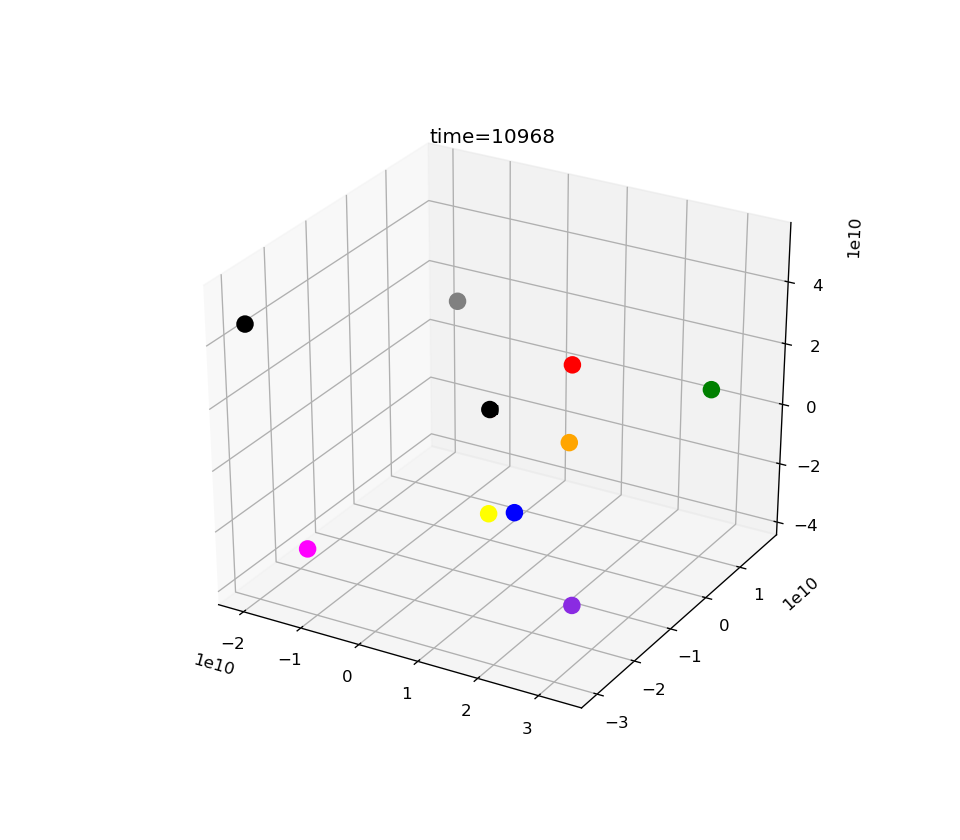

In [17]:
## ANIMATION 4: SIMPLE VERSION

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

%matplotlib notebook 

coord = np.copy(fixed_coord)##
vel = np.copy(fixed_vel)

step = np.zeros(n_pkt, dtype=int) #current step

done = [False for x in packets]
def update_graph(num,coord,start_times,arrival_times,step,n_pkt,vel,done):
    
    speed = 1.5   #animation speed
    time = num * speed
    
    for i in range(n_pkt):
        if done[i]:
            continue
  
        start = start_times[i][step[i]]
        end = arrival_times[i][step[i]]
        
        if time < start:
            status = "waiting"
        elif start <= time <= end:
            status = "midair"
        elif time > end:
            status = "arrived"
        if status == "midair":
            coord[i,:] = coord[i,:] + vel[i,:] * speed
            
        elif status == "waiting":
            pass
        elif status == "arrived":
            try:
                step[i] += 1
                vel[i,:] = get_vel(coord_nodes[path[i][step[i]],:], coord_nodes[path[i][step[i]+1],:])
                start = start_times[i][step[i]]
                end = arrival_times[i][step[i]]
            except IndexError:
                done[i] = True

    
    graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
    title.set_text("time={}".format(num))


fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Pkts')

cnodes = ["black","red","orange","yellow","green","blue","magenta","blueviolet","grey","black"]

pkt_color = [cnodes[pkt.source] for pkt in packets]
graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2],s=20,color=pkt_color,marker="s")

ax.scatter(coord_nodes[:,0],coord_nodes[:,1],coord_nodes[:,2],s=90,color=cnodes,alpha=1)
ax.scatter(0,0,0,color="red",s=60)   #Earth

ani4 = animation.FuncAnimation(fig, update_graph, interval=5, blit=False,
                              fargs=(coord,start_times,arrival_times,step,n_pkt,vel,done))

plt.show()

# Conclusions 

Here we want to sum up the results of our efforts by recapping which were the initial objectives and how the two 
different approaches tackled the problem. 

So our goal was to find an effective routing algorithm in the scenario of Delay Tolerant Networks, where nodes are 
located very far from each other and the links are not always working. 

The first strategy which we studied and implemented is a greedy algorithm which turned out to be very efficient and 
probably the best type of approach when dealing with DTNs.
We can say that this algorithm is very efficient because Earth (which is the destination node) is always busy in the
sense that there are almost no idle times for the destination node which is always receiving packets.

Even if we are satisfied with the results we achieve with the greedy algorithm anyway more often than not we might not have
all the informations required by the greedy approach.

The alternative here is the epidemic algorithm which is not able to get to the same level of efficiency but is way more
robust because it works without requiring a complete knowledge of the future topology of the network.

# Bibliography

[1] Jain, Sushant, Kevin Fall, and Rabin Patra. "Routing in a delay tolerant network." Proceedings of the 2004 conference on Applications, technologies, architectures, and protocols for computer communications. 2004.<br>
[2] Evan P.C. Jone, Paul A.S. War. "Routing Strategies for Delay-Tolerant Networks."